# Análise Orçamentária e Forecast — Visão FP&A

Este notebook tem como objetivo simular uma análise padrão de FP&A (Financial Planning & Analysis) com base em dados fictícios contendo Orçado (Budget), Realizado (Actuals) e Forecast para diferentes departamentos ao longo de 12 meses.

A análise responde perguntas como:
- Estamos dentro do orçamento?
- O forecast atual reflete a realidade?
- Há sazonalidade nas despesas?
- Quais áreas estão mais distantes da meta?

Estrutura da Análise:
1. Carga e Preparação dos Dados: Limpeza inicial e garantia da qualidade dos dados.
2. Análise Agregada: Visão geral dos totais por departamento e desvios.
3. Análise de Série Temporal: Investigação da evolução mensal e possíveis sazonalidades.
4. Análise de Desvio (Heatmap): Identificação visual dos meses e departamentos mais críticos.

Dados simulados no arquivo: `dados/orcamento_empresa.csv`

Ferramentas: A análise será conduzida em `Python`, utilizando principalmente as bibliotecas `pandas`, `matplotlib` e `seaborn`.

#### Importando os Dados

In [58]:
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# ----------------------------
import pandas as pd                      # Manipulação de dados
import matplotlib.pyplot as plt          # Visualização gráfica
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns                    # Estilização de gráficos
from IPython.display import display      # Exibição formatada no notebook

# 2. LEITURA DOS DADOS
# --------------------
df = pd.read_csv(
    "../dados/orcamento_empresa.csv",    # Caminho do arquivo
    encoding="utf-8-sig",                # Suporte a acentuação
    parse_dates=["Data"]                 # Converte a coluna "Data" para datetime
)

#### Análise Geral por Departamento

In [59]:
# --- 1. CÁLCULOS NUMÉRICOS ---
# Agrupa os dados por departamento e soma os valores de cada coluna
resumo = df.groupby("Departamento")[["Orcado", "Realizado", "Forecast"]].sum()

# Calcula o desvio entre o realizado e o orçado (valor absoluto e percentual)
resumo["Desvio_Real"] = resumo["Realizado"] - resumo["Orcado"]
resumo["Desvio_%"] = resumo["Desvio_Real"] / resumo["Orcado"]

# --- 2. FORMATAÇÃO PARA EXIBIÇÃO ---
# Aplica formatação brasileira de moeda e percentual para exibição no notebook
display(
    resumo.style
        .format(
            {
                "Orcado": "R$ {:,.2f}",
                "Realizado": "R$ {:,.2f}",
                "Forecast": "R$ {:,.2f}",
                "Desvio_Real": "R$ {:+,.2f}",  # Exibe sinal "+" para valores positivos
                "Desvio_%": "{:.2%}"
            },
            decimal=",",                     # Usa vírgula como separador decimal
            thousands="."                    # Usa ponto como separador de milhar
        )
        .set_caption("Resumo Financeiro por Departamento")  # Título da tabela
)

,Orcado,Realizado,Forecast,Desvio_Real,Desvio_%
Departamento,,,,,
Financeiro,"R$ 308.848,54","R$ 296.263,58","R$ 319.089,85","R$ -12.584,96","-4,07%"
Marketing,"R$ 287.742,93","R$ 281.259,14","R$ 278.900,21","R$ -6.483,79","-2,25%"
Operações,"R$ 290.912,50","R$ 285.308,52","R$ 294.693,27","R$ -5.603,98","-1,93%"
RH,"R$ 191.381,92","R$ 195.261,44","R$ 185.940,14","R$ +3.879,52","2,03%"
TI,"R$ 256.962,36","R$ 248.853,50","R$ 261.850,81","R$ -8.108,86","-3,16%"


#### Gráfico de Barras

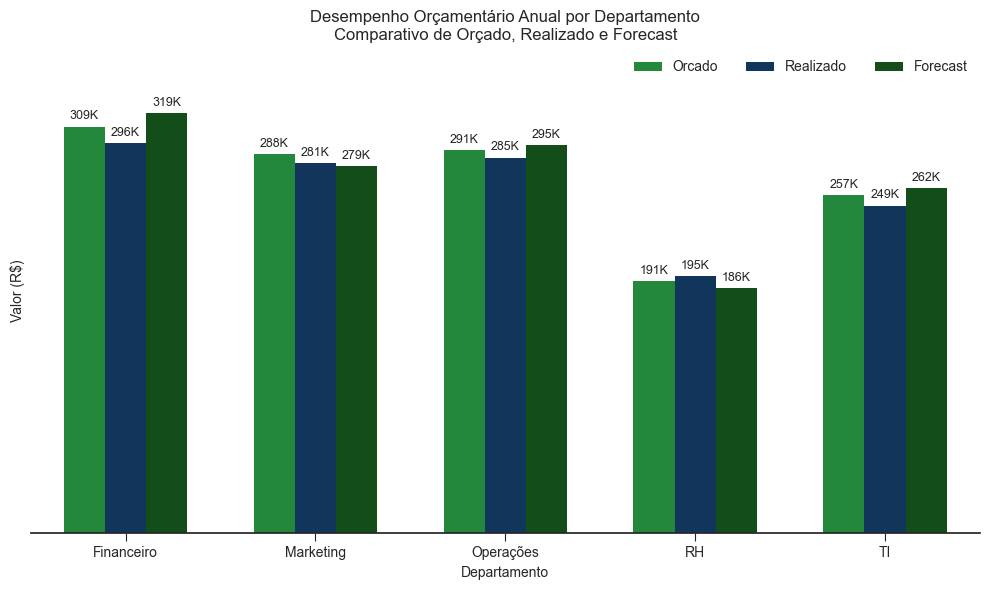

In [60]:
# --- 1. CONFIGURAÇÃO E CRIAÇÃO DO GRÁFICO ---
plt.style.use('seaborn-v0_8-ticks')                 # Estilo visual do gráfico
fig, ax = plt.subplots(figsize=(10, 6))             # Cria a figura e o eixo

# Prepara os dados com melt e plota o gráfico de barras agrupadas
sns.barplot(
    data=resumo.reset_index().melt(
        id_vars='Departamento',
        value_vars=['Orcado', 'Realizado', 'Forecast'],
        var_name='Tipo de Valor'
    ),
    x='Departamento',
    y='value',
    hue='Tipo de Valor',
    palette={                                     # Cores personalizadas
        "Orcado": "#129833",
        "Realizado": "#063667",
        "Forecast": "#095812"
    },
    ax=ax,
    width=0.65
)

# --- 2. ESTILIZAÇÃO E RÓTULOS ---
# Adiciona rótulos em cima das barras (valores em milhar, com "K")
for container in ax.containers:
    labels = [f'{v/1000:.0f}K' for v in container.datavalues]
    ax.bar_label(container, labels=labels, size=9, padding=3)

# Define título e rótulos dos eixos
ax.set(
    xlabel="Departamento",
    ylabel="Valor (R$)",
    title="Desempenho Orçamentário Anual por Departamento\nComparativo de Orçado, Realizado e Forecast"
)

# Ajusta o eixo Y para dar espaço aos rótulos e remove os ticks
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.set_yticks([])

# Remove bordas laterais e configura legenda
sns.despine(left=True)
ax.legend(title=None, frameon=False, loc='upper right', ncol=3)

# --- 3. EXIBIÇÃO ---
plt.tight_layout()
plt.show()

#### Evolução Mensal do Orçamento

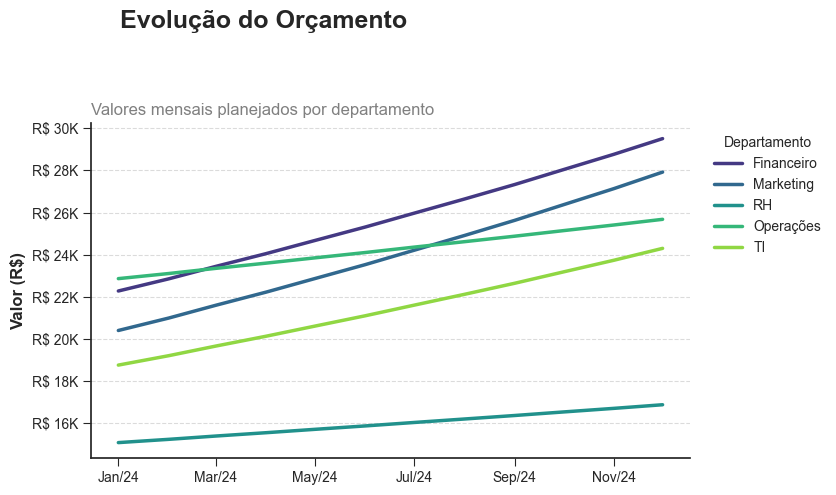

In [61]:
# --- 1. PREPARAÇÃO E CONFIGURAÇÃO DE ESTILO ---
plt.style.use('seaborn-v0_8-ticks')  # Estilo visual limpo e corporativo

departamentos = df["Departamento"].unique()  # Lista de departamentos únicos

# Mapeia cada departamento para uma cor da paleta "viridis" (profissional e acessível)
cores_mapa = dict(zip(departamentos, sns.color_palette("viridis", n_colors=len(departamentos))))

# --- 2. FUNÇÃO DE PLOTAGEM ---
def plot_evolucao_corp(metrica, titulo, subtitulo):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plota uma linha para cada departamento
    for dept in departamentos:
        dados = df[df["Departamento"] == dept]
        ax.plot(
            dados["Data"], dados[metrica],
            label=dept,
            color=cores_mapa[dept],
            linewidth=2.5  # Linhas mais grossas para destaque visual
        )

    # Título principal e subtítulo
    fig.suptitle(titulo, ha='left', x=0.125, y=0.98, fontsize=18, weight='bold')
    ax.set_title(subtitulo, loc='left', fontsize=12, color='gray')

    # Rótulos dos eixos
    ax.set_xlabel(None)
    ax.set_ylabel("Valor (R$)", fontsize=12, weight='bold')

    # Formatação do eixo X com meses abreviados e do eixo Y em milhar
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b/%y"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'R$ {x/1000:.0f}K'))

    # Grade horizontal leve e remoção das bordas
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()

    # Legenda à direita, fora da área do gráfico
    ax.legend(title="Departamento", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    # Ajuste para evitar que a legenda seja cortada
    fig.tight_layout(rect=[0, 0, 0.85, 0.9])
    plt.show()

# --- 3. EXECUÇÃO ---
plot_evolucao_corp(
    "Orcado",
    "Evolução do Orçamento",
    "Valores mensais planejados por departamento"
)

#### Evolução Mensal do Realizado


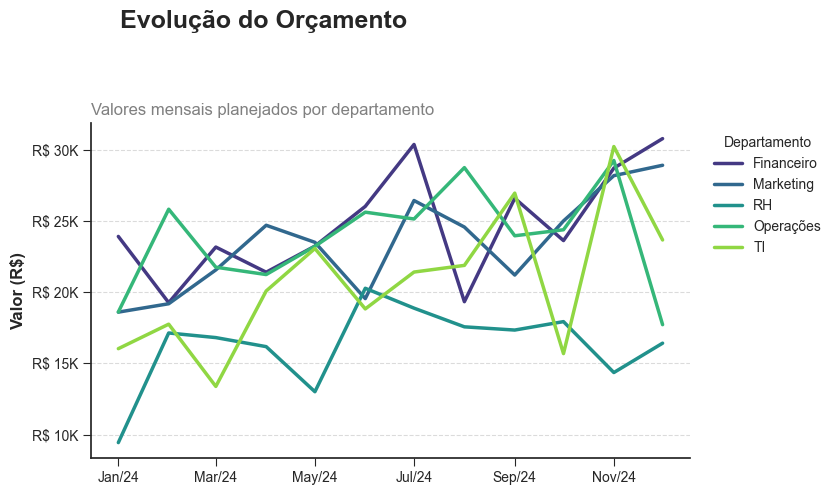

In [62]:
plot_evolucao_corp(
    "Realizado",
    "Evolução do Orçamento",
    "Valores mensais planejados por departamento"
)

#### Evolução Mensal do Forecast

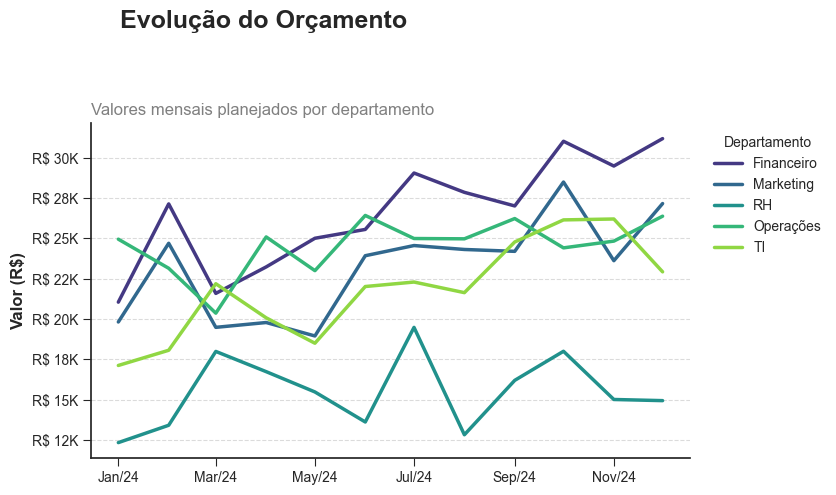

In [63]:
plot_evolucao_corp(
    "Forecast",
    "Evolução do Orçamento",
    "Valores mensais planejados por departamento"
)

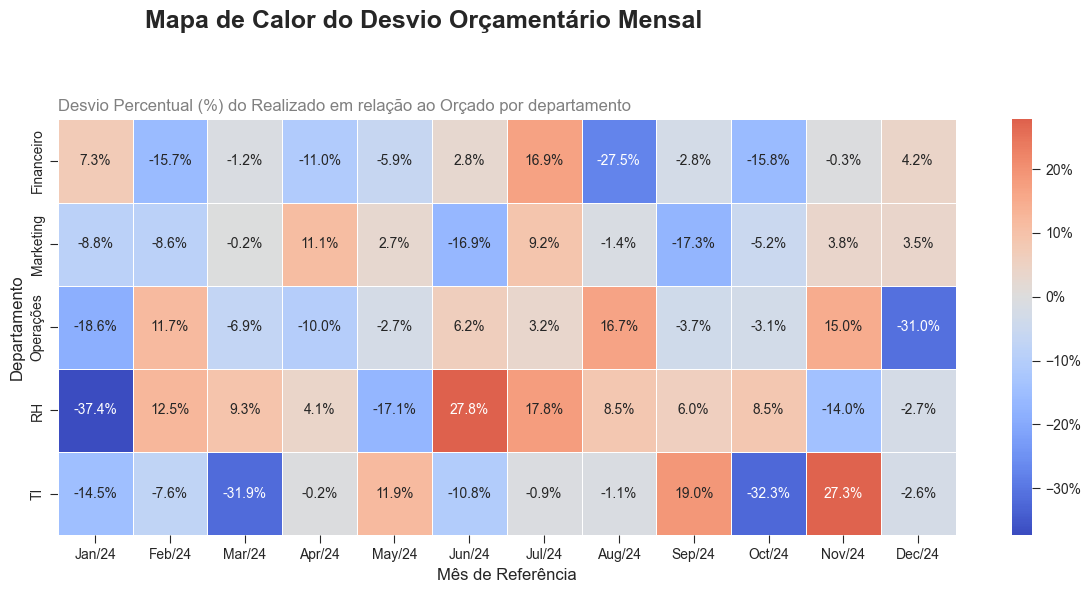

In [64]:
# --- 1. PREPARAÇÃO DOS DADOS ---
df["Data"] = pd.to_datetime(df["Data"], format="%d-%b-%Y")  # Garante tipo datetime
df = df.sort_values("Data")                                # Ordena por data

# Calcula o desvio percentual entre Realizado e Orçado
df["Desvio_%"] = (df["Realizado"] - df["Orcado"]) / df["Orcado"]

# Reestrutura os dados no formato Departamento x Data
heatmap_data = df.pivot(index="Departamento", columns="Data", values="Desvio_%")

# Formata as datas para o eixo X (ex: Jan/25)
heatmap_data.columns = [col.strftime("%b/%y") for col in heatmap_data.columns]

# --- 2. PLOTAGEM DO HEATMAP ---
plt.style.use('seaborn-v0_8-ticks')             # Estilo visual
fig, ax = plt.subplots(figsize=(12, 6))         # Tamanho da figura

# Cria o mapa de calor com valores anotados e barra percentual
sns.heatmap(
    heatmap_data,
    annot=True,                                 # Exibe valores dentro das células
    fmt=".1%",                                  # Formato percentual com 1 casa
    cmap="coolwarm",                            # Paleta de cores centrada
    center=0,                                   # Centro da escala em 0
    linewidths=0.5,                             # Linhas entre as células
    ax=ax,
    cbar_kws={'format': ticker.PercentFormatter(xmax=1, decimals=0)}  # Barra de cor em %
)

# --- 3. AJUSTES VISUAIS E TÍTULOS ---
fig.suptitle(
    "Mapa de Calor do Desvio Orçamentário Mensal",
    ha='left', x=0.125, y=0.98, fontsize=18, weight='bold'
)
ax.set_title(
    "Desvio Percentual (%) do Realizado em relação ao Orçado por departamento",
    loc='left', fontsize=12, color='gray'
)

# Rótulos dos eixos
ax.set_xlabel("Mês de Referência", fontsize=12)
ax.set_ylabel("Departamento", fontsize=12)

# Rótulos do eixo X na horizontal
plt.xticks(rotation=0)

# Ajuste para exibir tudo corretamente com o título
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## Conclusão

Com base na consolidação anual de 2024, os principais insights da análise orçamentária por departamento são:

- Financeiro foi o departamento com maior orçamento total (R$ 308.848,54), mas apresentou desvio negativo de -4,07%, sinalizando subexecução. Apesar disso, manteve uma boa proximidade com o forecast.

- Marketing e Operações também operaram com valores próximos ao planejado, com desvios de -2,25% e -1,93%, respectivamente, o que demonstra boa aderência orçamentária.

- RH foi o único departamento que ultrapassou o orçamento, com desvio positivo de +2,03%, indicando uma possível revisão de provisões ou custos inesperados.

- TI teve um desempenho abaixo do orçamento com desvio de -3,16%, mas alinhado ao forecast, o que sugere um planejamento ajustado ao longo do ano.

O heatmap de desvios mensais revelou que o maior impacto orçamentário ocorreu de forma pontual, sem recorrência excessiva em nenhum departamento, com exceções isoladas em RH (junho/julho) e TI (março/outubro).